In [10]:
import os
import ast
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import KFold

from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout
from keras import activations
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

from genreclassification.utils import get_project_root

import dataframe_image as dfi
pd.set_option("display.max_columns", None)

# best performing mlnn from parameter search
---
## best parameters

In [46]:
gs_results = pd.read_pickle(
    get_project_root() / "output/gs_results_20221217.pkl"
)

best = gs_results[gs_results["accuracy"] == gs_results["accuracy"].max()]
best = best["params"].reset_index(drop=True)[0]
best = ast.literal_eval(best)

---

## data split

In [26]:
df_30 = pd.read_csv(
    get_project_root() / "data/features_30_sec.csv"
)

df_3 = pd.read_csv(
    get_project_root() / "data/features_3_sec.csv"
)

### features / targets:

In [27]:
# get the target labels:
df_3_y = df_3["label"]

# find the training features:
df_3_x = df_3.drop(
    columns=["filename", "length", "label"]
)

### test split before scaling:

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    df_3_x,
    df_3_y,
    test_size=0.2,
    random_state=42
)

### MinMax scaling for the training set:

In [29]:
scaler = MinMaxScaler((0,1))
# scale fetures and get column names
scale_cols = x_train.columns
x_scaled = scaler.fit_transform(x_train[scale_cols])
# retrieve column names for scaled df:
x_train_scaled = pd.DataFrame(
    x_scaled,
    columns=scale_cols
)


---
### split training set into training and validation
* will eventually be training the model on all of the training data
* will split out a validation set here first to monitor overfitting

In [30]:
x_train_scaled, x_val_scaled, y_train, y_val = train_test_split(
    x_train_scaled,
    y_train,
    test_size=0.2,
    random_state=42
)

In [31]:
for d in [
    (x_train_scaled, "x_train_scaled"),
    (y_train, "       y_train"),
    (x_val_scaled, "  x_val_scaled"),
    (y_val, "         y_val")
]:
    print(f"{d[1]}: {d[0].shape}")

x_train_scaled: (6393, 57)
       y_train: (6393,)
  x_val_scaled: (1599, 57)
         y_val: (1599,)


---

### encoding the categorical classes
* the model will produce a probability score for each of the 10 classes, assigning the most likely label

In [32]:
# start by mapping the labels to numerical values:
catno_to_label = {key:value for (key, value) in enumerate(sorted(set(y_train)))}
# catno_to_label

In [33]:
# reverse this:
label_to_catno = {v:k for k,v in catno_to_label.items()}
# label_to_catno

In [34]:
y_train = y_train.map(label_to_catno)
y_val = y_val.map(label_to_catno)

label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)
y_val = label_as_binary.transform(y_val)

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

In [35]:
for d in [
    (x_train_scaled, "x_train"),
    (x_val_scaled, "  x_val"),
    (y_train, "y_train"),
    (y_val, "  y_val")
]:
    print(f"{d[1]}: {d[0].shape}")

x_train: (6393, 57)
  x_val: (1599, 57)
y_train: (6393, 10)
  y_val: (1599, 10)


---
### define model functions, same as gridsearch

#### build:

In [36]:
def build_mlnn(
    hidden_dim=128,
    activation_fn=activations.selu,
    dropout_rate=0.2
):
    model = Sequential(name="mlnn_genre_classification")
    #input layer
    model.add(Dense(
        units=32,
        activation=activation_fn,
        # kernel_regularizer=regularizers.l2(0.01),
        input_shape=(x_train_scaled.shape[1],),
        name="input")
    )
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # hidden layer
    model.add(Dense(
        units=hidden_dim,
        activation=activation_fn,
        # kernel_regularizer=regularizers.l2(0.01),
        name="hidden1"
    ))
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # hidden layer
    model.add(Dense(
        units=hidden_dim,
        activation=activation_fn,
        # kernel_regularizer=regularizers.l2(0.01),
        name="hidden2"
    ))
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # hidden layer
    model.add(Dense(
        units=hidden_dim,
        activation="selu",
        # kernel_regularizer=regularizers.l2(0.01),
        name="hidden3"
    ))
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(
        units=10,
        activation="softmax",
        name="output"
    ))

    return model

#### compile:

In [37]:
def mlnn_compile(
    model,
    optimiser=optimizers.Adam,
    learning_rate=0.0001
):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimiser(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    
    return model

#### fit:
* will have no validation data here as training on everything but test

In [50]:
def mlnn_fit(
    model,
    x,
    y,
    val_xy,
    epochs=700,
    batch_size=32,
):
    history=History()
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        restore_best_weights=True,
        patience=epochs,
        baseline=None
    )

    model.fit(
        x,
        y,
        validation_data=val_xy,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[
            history,
            early_stopping
        ]
    )

    return model, history

In [51]:
model = build_mlnn(
    hidden_dim=best["hidden_dim"],
    dropout_rate=best["dropout_rate"]
)

model = mlnn_compile(
    model,
    learning_rate=best["learning_rate"]
)

model, history = mlnn_fit(
    model,
    x_train_scaled,
    y_train,
    (x_val_scaled, y_val),
    epochs=1300,
    batch_size=best["batch_size"]
)

Epoch 1/1300
200/200 [==============================] - 2s 4ms/step - loss: 1.5243 - accuracy: 0.4758 - val_loss: 1.5812 - val_accuracy: 0.4078
Epoch 2/1300
200/200 [==============================] - 1s 3ms/step - loss: 1.2011 - accuracy: 0.5777 - val_loss: 1.0249 - val_accuracy: 0.6529
Epoch 3/1300
200/200 [==============================] - 1s 3ms/step - loss: 1.0863 - accuracy: 0.6213 - val_loss: 0.9624 - val_accuracy: 0.6748
Epoch 4/1300
200/200 [==============================] - 1s 3ms/step - loss: 1.0136 - accuracy: 0.6471 - val_loss: 0.9167 - val_accuracy: 0.6823
Epoch 5/1300
200/200 [==============================] - 1s 3ms/step - loss: 0.9552 - accuracy: 0.6615 - val_loss: 0.8257 - val_accuracy: 0.7255
Epoch 6/1300
200/200 [==============================] - 1s 3ms/step - loss: 0.9285 - accuracy: 0.6679 - val_loss: 0.8372 - val_accuracy: 0.7148
Epoch 7/1300
200/200 [==============================] - 1s 3ms/step - loss: 0.9007 - accuracy: 0.6829 - val_loss: 0.9088 - val_accuracy:

### check there is not drastic overfitting:

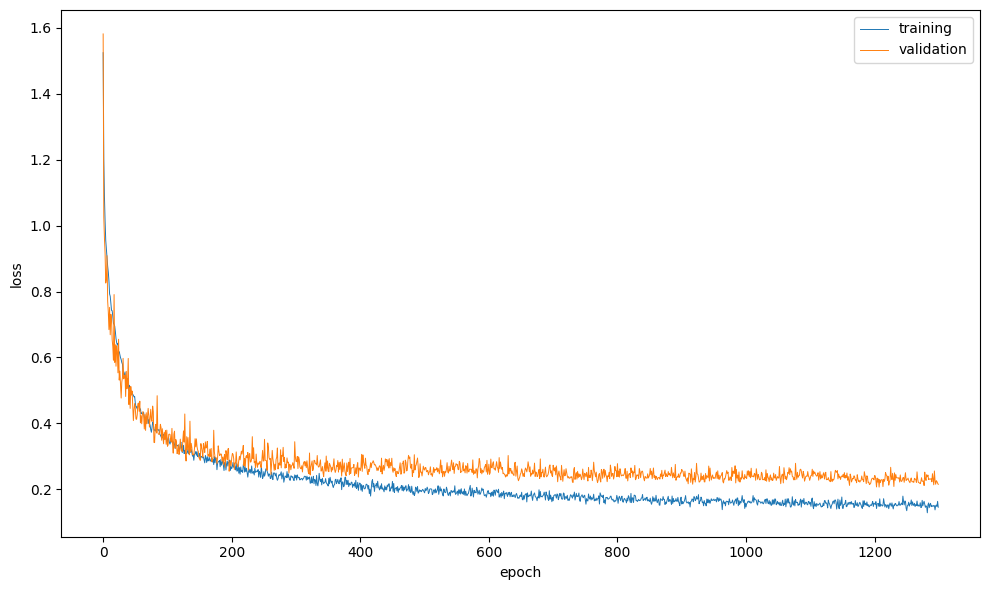

In [52]:
fig = plt.figure(
    figsize=(10,6)
)
ax = fig.add_subplot(111)

ax.plot(history.history["loss"], label="training", linewidth=0.7)
ax.plot(history.history["val_loss"], label="validation", linewidth=0.7)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

fig.tight_layout()

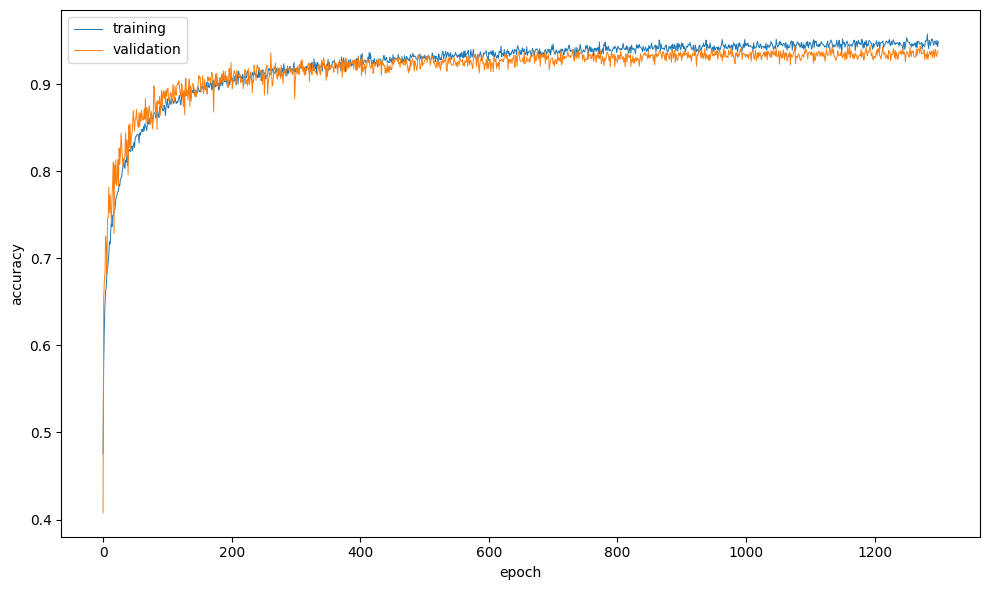

In [53]:
fig = plt.figure(
    figsize=(10,6)
)
ax = fig.add_subplot(111)

ax.plot(history.history["accuracy"], label="training", linewidth=0.7)
ax.plot(history.history["val_accuracy"], label="validation", linewidth=0.7)

ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()

fig.tight_layout()

### save training fig:

In [54]:
# fig.savefig(
#     get_project_root() / "output/mlnn/best_mlnn_training.svg"
# )
# fig.savefig(
#     get_project_root() / "output/mlnn/best_mlnn_training.png"
# )

### save model:

In [55]:
# model.save(
#     get_project_root() / "models/best_mlnn/best_mlnn"
# )

INFO:tensorflow:Assets written to: /Users/djq98242/repos/genre_classification/models/best_mlnn/best_mlnn/assets
